In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, hstack
import sys, os
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')

In [2]:
from hsc_gaap.gaap import consolidateMerianCats
import itertools

Overriding default configuration file with /projects/HSC/LSST/stack_20220527/conda/envs/lsst-scipipe-4.1.0/share/eups/Linux64/dustmaps_cachedata/g41a3ec361e+62d12e78cb/config/.dustmapsrc


In [3]:
old_patches = [name for name in os.listdir(
    "/projects/MERIAN/repo/S20A/deepCoadd_calexp/9813/")]
new_patches = [int(name[0]) + int(name[2]) * 9 for name in old_patches]
merian_patches = [int(name) for name in os.listdir(
    "/projects/MERIAN/repo/DECam/runs/merian/dr1_wide/20220921T193246Z/deepCoadd_forced_src/9813")]
common_patches = np.intersect1d(new_patches, merian_patches)
common_patches = [(patch%9, patch//9) for patch in common_patches]

In [4]:
len(common_patches)

66

In [5]:
patch_cols = [0,1,2,3,4,5,6,7,8]
patch_rows = [0,1,2,3,4,5,6,7,8]

patches_old = common_patches #list(itertools.product(patch_cols, patch_rows))

In [7]:
import time

In [8]:
'/projects/MERIAN/repo/S20A/gaapTable/9813/1,7/objectTable_9813_1,7_S20A.fits')

In [12]:
ti_m

1671911548.0612886

In [15]:
filedir = '/projects/MERIAN/repo/S20A/gaapTable/9813/'

good_patches = []

for patch in patches_old:
    patch_name = f'{patch[0]},{patch[1]}'
    filename = os.path.join(filedir, patch_name, f'objectTable_9813_{patch_name}_S20A.fits')
    if os.path.isfile(filename):
        filesize = os.path.getsize(filename) / 1024**2
        fileday = time.gmtime(os.path.getmtime(filename)).tm_mday
#         print("File Size is :", filesize, "Mb")
        if filesize > 100 and fileday > 22:
            good_patches.append(patch)
        else:
            print(patch_name, 'is not good!', 'Filesize = ', filesize)
    else:
        print(patch_name, ', No such file')

7,4 is not good! Filesize =  190.711669921875
7,8 is not good! Filesize =  43.253173828125


In [12]:
len(patches_old)

81

In [13]:
len(good_patches)

62

In [48]:
for patch in good_patches[:1]:
    patch_name = f'{patch[0]},{patch[1]}'
    filename = os.path.join(filedir, patch_name, f'objectTable_9813_{patch_name}_S20A.fits')
    cat = Table.read(filename)
    merian = consolidateMerianCats([0], tract=9813)
    if np.sum(merian['objectId'] != cat['objectId']) > 0:
        raise ValueError('Merian catalog does not match with HSC catalog')
    else:
        hsc_cols = [item for item in cat.colnames if 'g_' in item or 'r_' in item or 'i_' in item or 'z_' in item or 'y_' in item]
        # only photometry columns
        cat = hstack([merian, cat[hsc_cols]]).to_pandas()
        # Have to save in H5 since there are >999 columns in the table
        # FITS cannot handle it
        
        filename = os.path.join(filedir, patch_name, f'objectTable_9813_{patch_name}_S20A_MDR1.h5')
        cat.to_hdf(filename, key='df', mode='w')

In [51]:
from hsc_gaap.gaap import consolidateObjectTables

In [52]:
cat = consolidateObjectTables([patch[0] + patch[1] * 9 for patch in good_patches])

In [53]:
len(cat)

895436

In [54]:
cat.write('/tigress/jiaxuanl/public_html/Merian/objectTable_S20A_221208.fits', overwrite=True)

In [3]:
# cat = joinCatBands(patch=23, filters='ri', hsc_type='S20A')

In [ ]:
cat = joinCatPatches(patches=[22, 23, 24, 25, 31, 32, 33, 34, 40, 41, 42, 43], filters='gri', hsc_type='S20A')

In [ ]:
cat.write('/tigress/jiaxuanl/public_html/Merian/gri_S20A_patch22_43.fits', overwrite=True)

In [32]:
merian = joinMerianCatPatches(patches=[22, 23, 24, 25], tract=9813)

In [33]:
merian.write('/tigress/jiaxuanl/public_html/Merian/Merian_patch22_25.fits', overwrite=True)

In [34]:
np.sum(cat['id'] != merian['objectId'])

0

---

In [21]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [170]:
hsc_type = 'S20A'
cat = Table.read(f'/tigress/jiaxuanl/public_html/Merian/gri_{hsc_type}_patch22_25.fits')
merian = Table.read('/tigress/jiaxuanl/public_html/Merian/Merian_patch22_25.fits')
merian.remove_columns(['objectId', 'coord_ra', 'coord_dec'])
cat = hstack([cat, merian])

In [171]:
cosmos = Table.read('/tigress/jiaxuanl/public_html/Merian/cosmos_merian_dr1_broadcut4jiaxuan.fits')
cosmos = cosmos[[item for item in cosmos.keys() if 'gaap' not in item ]]

In [172]:
# Match two catalogs
_cosmos = SkyCoord(ra=cosmos['ALPHA_J2000'], dec=cosmos['DELTA_J2000'], unit='deg')
_cat = SkyCoord(ra=cat['coord_ra'], dec=cat['coord_dec'], unit='deg')
temp = _cosmos.match_to_catalog_sky(_cat)
flag = (temp[1] < 0.8 * u.arcsec)

cat = hstack([cosmos[flag], cat[temp[0][flag]]])

In [137]:
import kuaizi
kuaizi.set_matplotlib(style='JL', usetex=True, dpi=80, fontsize=20)

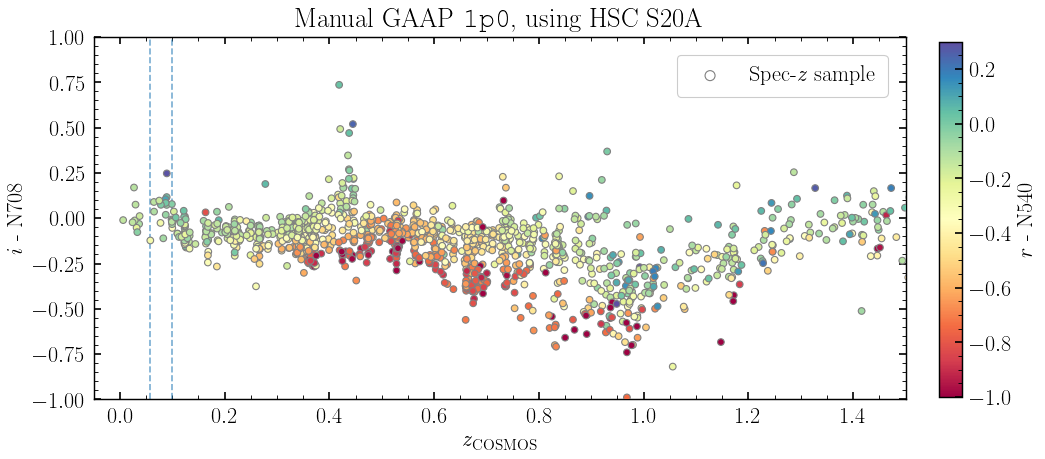

In [138]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), sharey=True)

plt.sca(axes)
aper = '1p0'
flag = cat['spec_z']
sct = plt.scatter(cat['z_cosmos'][flag],
                  - 2.5 * np.log10(cat[f'i_gaap{aper}Flux'] /
                           cat[f'N708_gaap{aper}Flux'])[flag],
                  c=-2.5 * np.log10(cat[f'r_gaap{aper}Flux'] /
                           cat[f'N540_gaap{aper}Flux'])[flag],
                  cmap='Spectral', vmin=-1.0, vmax=0.3, 
                  edgecolors='gray', zorder=30, label='Spec-$z$ sample')

# sct = plt.scatter(cat['z_cosmos'][~flag],
#                   - 2.5 * np.log10(cat[f'i_gaap{aper}Flux'] /
#                            cat[f'N708_gaap{aper}Flux'])[~flag],
#                   c=-2.5 * np.log10(cat[f'r_gaap{aper}Flux'] /
#                            cat[f'N540_gaap{aper}Flux'])[~flag],
#                   cmap='Spectral', vmin=-1.0, vmax=0.3, edgecolors='none', 
#                   label='Photo-$z$ sample')

plt.axvline(0.058, ls='--', alpha=0.6)
plt.axvline(0.10, ls='--', alpha=0.6)
plt.ylim(-1, 1.0)
plt.xlim(-0.05, 1.5)
plt.title(r'Manual GAAP $\texttt{1p0}$, ' + f'using HSC {hsc_type}')
plt.xlabel('$z_\mathrm{COSMOS}$')
plt.ylabel('$i$ - N708')
leg = plt.legend(fontsize=20, scatterpoints=1, frameon=True, markerscale=1.5)
leg.legendHandles[0].set_facecolor('none')


fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.13, 0.02, 0.74])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label('$r$ - N540')
# for t in cbar.ax.get_label():
#     t.set_fontsize(18)

# # fig.colorbar(im, cax=cax, orientation='vertical')
# fig.colorbar(sct, cax=cax, label='$r$ - N540', )
plt.subplots_adjust(wspace=0.05)
# plt.savefig(f'/tigress/jiaxuanl/public_html/Merian/manual_gaap_excess_plot_{hsc_type}.png', 
#             dpi=100, bbox_inches='tight')

---

### SNR, aperture

In [163]:
hsc_type = 'S20A'
cat = Table.read(f'/tigress/jiaxuanl/public_html/Merian/gri_{hsc_type}_patch22_25.fits')
# merian = Table.read('/tigress/jiaxuanl/public_html/Merian/Merian_patch22_25.fits')
# merian.remove_columns(['objectId', 'coord_ra', 'coord_dec'])
# cat = hstack([cat, merian])

In [190]:
good_objects = ~(cat["i_gaap_flag"] | cat['i_gaapOptimalFlux_flag_bigPsf'])
good_objects &= flag
np.sum(good_objects), len(good_objects)

(1490, 6155)

In [174]:
baseNames = [item for item in cat.colnames if 'i_gaap' in item and 'Flux' in item and 'flag' not in item and 'Err' not in item and 'Psf' not in item]

In [189]:
flag = cat['mass_cosmos'] < 9

Text(0.5, 0.98, 'COSMOS dwarf galaxies ($\\log M_\\star < 9$)')

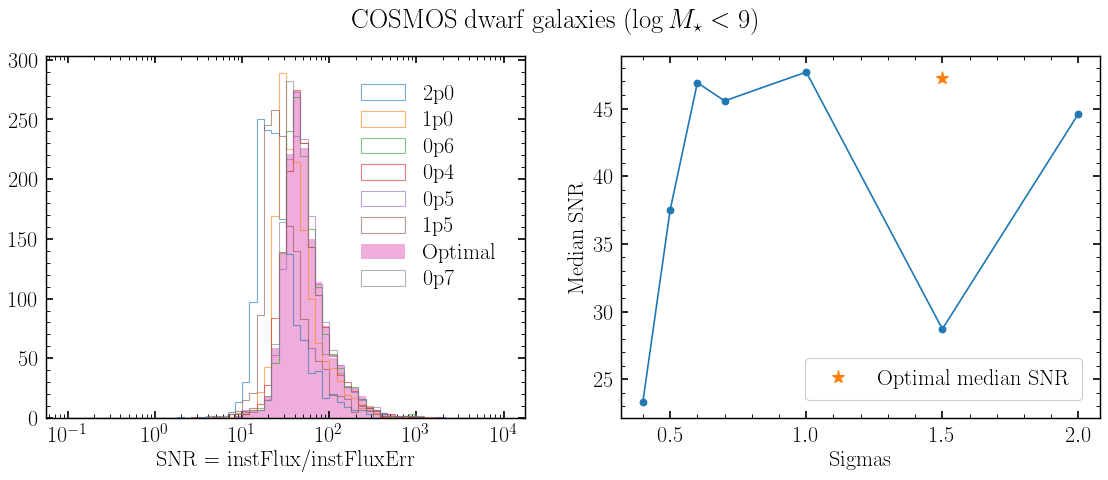

In [193]:
fig, ax = plt.subplots(1, 2, figsize=(17,6))
bins = np.logspace(-1, 4, 61)

statistic_list = []
statistic_upper_list, statistic_lower_list = [], []

for baseName in baseNames:
    label = baseName.replace('i_gaap','').replace('Flux','')
    histtype='stepfilled' if "Optimal" in baseName else 'step'
    snr = cat[baseName][good_objects] / cat[baseName+"Err"][good_objects]
    ax[0].hist(snr, bins=bins, histtype=histtype, label=label, alpha=0.6)
    statistic = np.nanpercentile(snr, 50)
    if "Optimal" in label:
        optStatistic = np.nanpercentile(snr, 50)
    if not ("PsfFlux" in label or "Optimal" in label):
        statistic_list.append(statistic)
        statistic_upper_list.append(np.percentile(snr, 84))
        statistic_lower_list.append(np.percentile(snr, 16))

    
ax[0].set_xscale('log')
ax[0].set_xlabel("SNR = instFlux/instFluxErr")
#ax[0].set_yscale('log')
ax[0].legend(loc='best')

sigmas = [0.4, 0.5, 0.6, 0.7, 1.0, 1.5, 2.0]
ax[1].plot(sigmas, statistic_list, 'o-')
# ax[1].fill_between(sigmas, statistic_upper_list, statistic_lower_list, alpha=0.4)
ax[1].plot(1.5, optStatistic, "*", markersize=12, label='Optimal median SNR')
plt.legend(frameon=True)
ax[1].set_ylabel("Median SNR")
ax[1].set_xlabel("Sigmas")

plt.suptitle(r'COSMOS dwarf galaxies ($\log M_\star < 9$)')

Text(0.5, 0, 'Sigmas')

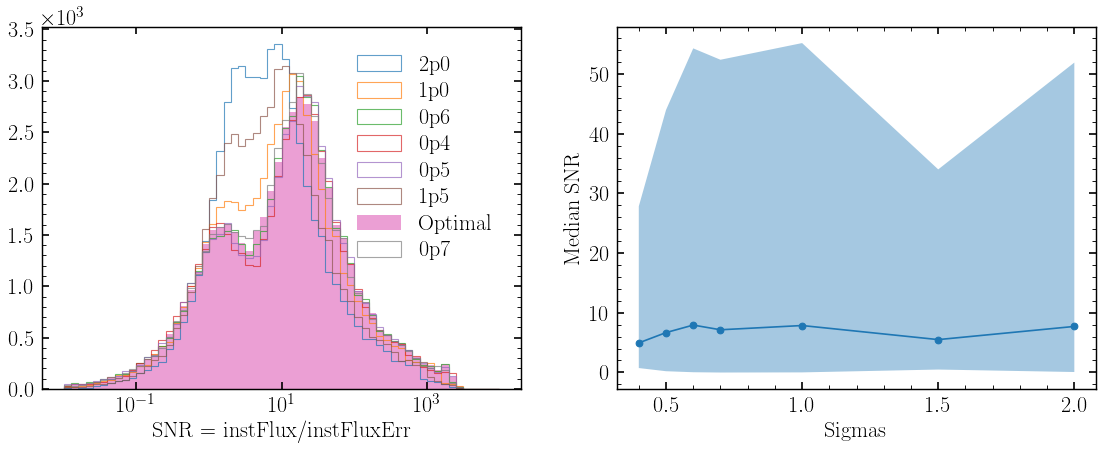

In [169]:
fig, ax = plt.subplots(1, 2, figsize=(17,6))
bins = np.logspace(-2, 4, 61)

statistic_list = []
statistic_upper_list, statistic_lower_list = [], []

for baseName in baseNames:
    label = baseName.replace('i_gaap','').replace('Flux','')
    histtype='stepfilled' if "Optimal" in baseName else 'step'
    snr = cat[baseName][good_objects] / cat[baseName+"Err"][good_objects]
    ax[0].hist(snr, bins=bins, histtype=histtype, label=label, alpha=0.7)
    statistic = np.nanpercentile(snr, 50)
    if "Optimal" in label:
        optStatistic = np.nanpercentile(snr, 50)
    if not ("PsfFlux" in label or "Optimal" in label):
        statistic_list.append(statistic)
        statistic_upper_list.append(np.percentile(snr, 84))
        statistic_lower_list.append(np.percentile(snr, 16))

    
ax[0].set_xscale('log')
ax[0].set_xlabel("SNR = instFlux/instFluxErr")
#ax[0].set_yscale('log')
ax[0].legend(loc='best')

sigmas = [0.4, 0.5, 0.6, 0.7, 1.0, 1.5, 2.0]
ax[1].plot(sigmas, statistic_list, 'o-')
ax[1].fill_between(sigmas, statistic_upper_list, statistic_lower_list, alpha=0.4)
# ax[1].plot(3.6, optStatistic, "*", markersize=12)
ax[1].set_ylabel("Median SNR")
ax[1].set_xlabel("Sigmas")